In [1]:
import numpy as np
import scipy as sp
import scipy.signal as sps
from PIL import Image
import matplotlib.pyplot as plt


Завантажую картинки в пітон

In [2]:
pics = []
for i in range(1,10):
    pics.append(Image.open(f"pic{i}.jpg"))

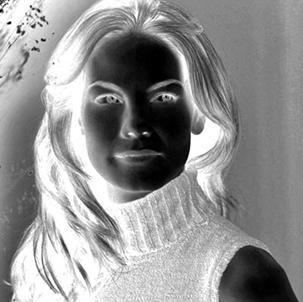

In [3]:
pics[0]

> Одразу зауваження: для обробки картинок я буду їх перетворювати в формат numpy ndarray, а потім назад 

In [14]:
nppic1 = np.asarray(pics[0])
nppic1, nppic1.max()

(array([[ 50, 117,  93, ..., 158, 161, 161],
        [ 94,  35,  77, ..., 161, 162, 161],
        [125,  64,  85, ..., 162, 160, 158],
        ...,
        [ 91,  90,  87, ..., 132, 131, 132],
        [ 91,  89,  88, ..., 138, 129, 128],
        [ 89,  88,  87, ..., 140, 126, 122]], dtype=uint8),
 255)

Тут бачимо, що це grayscale зображення складається зі значень від 0 до 255. $L=256$

# 1. Інверсія

$G_{ij} = 255 - F_{ij}$

In [18]:
def filter_invert(img):
    npimg = np.asarray(img)
    resimg = 255 - npimg
    return Image.fromarray(resimg)

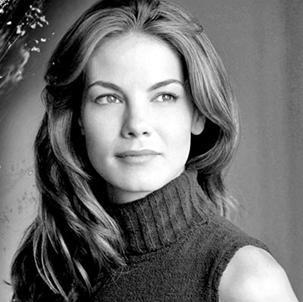

In [19]:
filter_invert(pics[0])

# 2. Логарифмічне перетворення

Параметри: $c, b$

$G_{ij} = c \log_b F_{ij}$

In [103]:
def filter_log(img, c=1, b=10):
    npimg = np.asarray(img)
    resimg = ( c * np.log(1 + npimg) / np.log(b) ).astype(np.uint8)
    resimg = np.clip(resimg, 0, 255) # цей рядок обмежує значення пікселів на [0,255]
    return Image.fromarray(resimg)

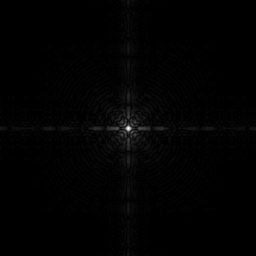

In [114]:
pics[1]

C:\Users\mkrooted\AppData\Local\Temp\ipykernel_6616\2468537360.py:3: RuntimeWarning: divide by zero encountered in log
  resimg = ( c * np.log(1 + npimg) / np.log(b) ).astype(np.uint8)


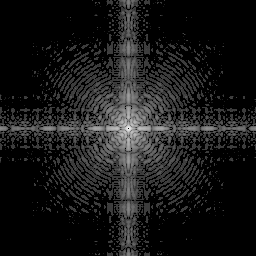

In [136]:
img = filter_log(pics[1], 100, 10)
img

Text(0.5, 1.0, 'histograms')

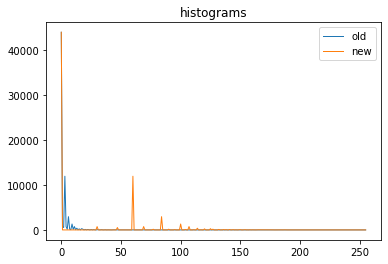

In [149]:
plt.plot(pics[1].histogram(), label='old', lw=1)
plt.plot(img.histogram(), label='new', lw=1)
plt.legend()
plt.title('histograms')

# 3. Степеневе перетворення

Параметри: $c, \gamma$

$G_{ij} = c \cdot F_{ij}^\gamma, \quad F, G \in [0,1]$

Тут треба буде перевести з [0,255] в [0,1] і назад

In [121]:
def filter_gamma(img, c=1, g=0.5):
    npimg = np.asarray(img)
    resimg = ( 255 * c * np.float_power( npimg/255 , g ) ).astype(np.uint8)
    resimg = np.clip(resimg, 0, 255) # цей рядок обмежує значення пікселів на [0,255]
    return Image.fromarray(resimg)

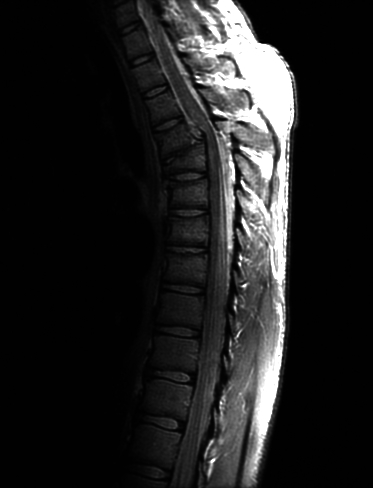

In [122]:
pics[2]

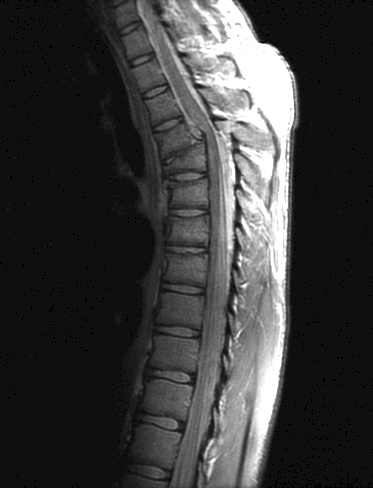

In [151]:
img = filter_gamma(pics[2], 1, 0.5)
img

Text(0.5, 1.0, 'histograms')

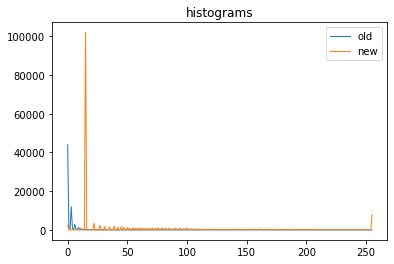

In [152]:
plt.plot(pics[1].histogram(), label='old', lw=1)
plt.plot(img.histogram(), label='new', lw=1)
plt.legend()
plt.title('histograms')

# 4. Розтягнення контрасту

$G_{ij} = \frac{1}{1 + (m/F_{ij})^E}$

In [132]:
def filter_contrast(img, m, e):
    npimg = np.asarray(img) / 255
    resimg = ( 255 / ( 1 + np.float_power(m/npimg, e)) ).astype(np.uint8)
    resimg = np.clip(resimg, 0, 255) # цей рядок обмежує значення пікселів на [0,255]
    return Image.fromarray(resimg)

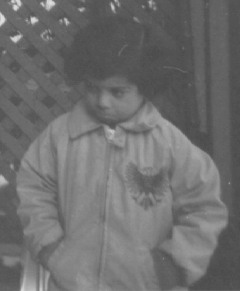

In [159]:
pics[3]

In [160]:
np.asarray(pics[3]).mean()

110.30465349369989

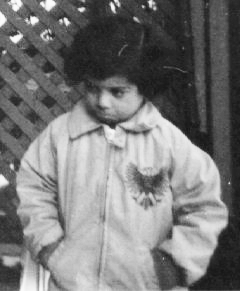

In [240]:
img = filter_contrast(pics[3], 110/255, 6)
img

Text(0.5, 1.0, 'histograms')

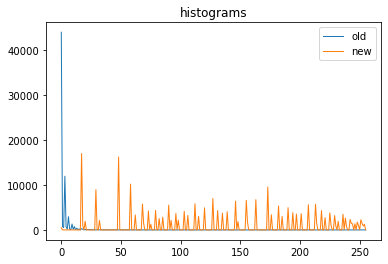

In [230]:
plt.plot(pics[1].histogram(), label='old', lw=1)
plt.plot(img.histogram(), label='new', lw=1)
plt.legend()
plt.title('histograms')

Тут варто погратися з параметрами, щоб знайти ту форму сигмоіди, яка найкраще розтягує потрібний інтервал інтенсивностей. Найкраще фільтр працює, якщо сигмоіда відцентрована на середнє значення яскравості. Його я знайшов через `np.asarray(pics[3]).mean()` що дало значення `110`. Це відповідає параметру `m = 110/255`.

Другий параметр регулює ширину сигмоіди. Треба підібрати таке значення, щоб максимально масштабувати цікавий нам діапазон яскравостей біля середини сігмоіди, але не перетворити її на сходинкову функцію (коли перепад занадто стрімкий) 

# 5. Еквалізація гістограм

In [195]:
def filter_histeq(img):
    npimg = np.asarray(img)
    hist = np.asarray(img.histogram())
    ntotal = hist.sum()
    lookup = hist.cumsum() / ntotal
    # Тепер достатньо використати старі значення пікселів як індекси для lookup
    # А потім поділити на загальну кількість пікселів
    resimg = (lookup[npimg] * 255).astype(np.uint8)
    return Image.fromarray(resimg)



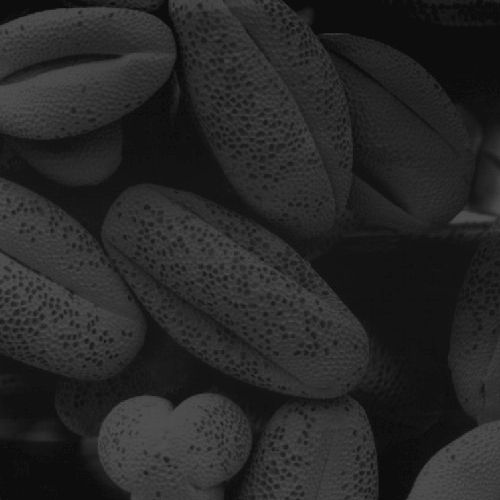

In [196]:
pics[4]

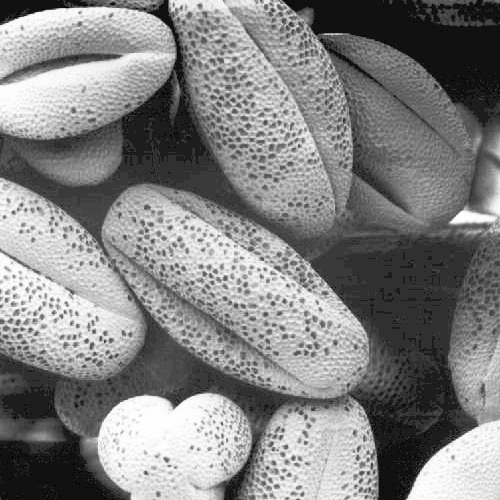

In [197]:
img = filter_histeq(pics[4])
img

Text(0.5, 1.0, 'histograms')

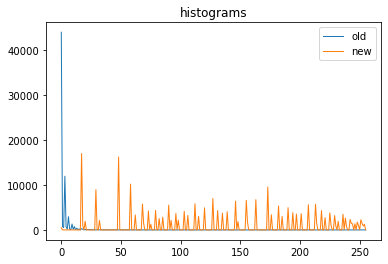

In [198]:
plt.plot(pics[1].histogram(), label='old', lw=1)
plt.plot(img.histogram(), label='new', lw=1)
plt.legend()
plt.title('histograms')

# 6. Згладжування усереднюючим фільтром

In [205]:
def filter_blur(img, r):
    w = np.ones((r,r))
    factor = r*r
    resimg = (sps.convolve2d(np.asarray(img), w) / factor).astype(np.uint8)
    return resimg

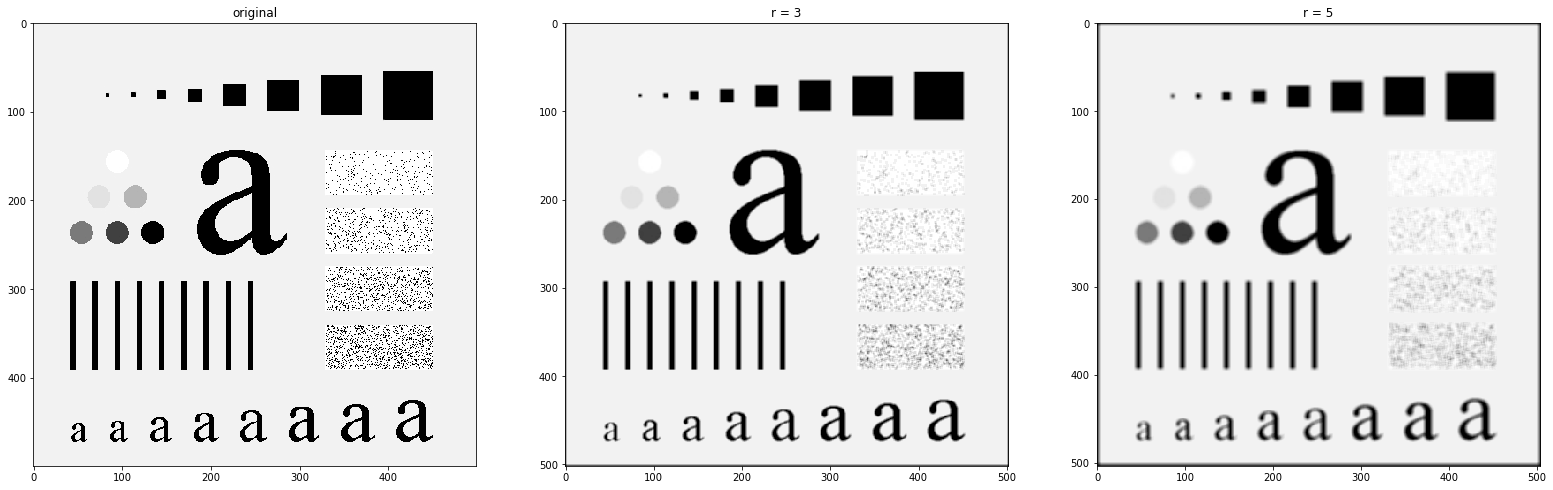

In [229]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(pics[5], cmap='Greys_r', interpolation='nearest')
axs[0].set_title('original')
axs[1].imshow(filter_blur(pics[5], 3), cmap='Greys_r', interpolation='nearest')
axs[1].set_title('r = 3')
axs[2].imshow(filter_blur(pics[5], 5), cmap='Greys_r', interpolation='nearest')
axs[2].set_title('r = 5')
fig.set_size_inches((27,9))

# 7. Маска Лапласа та підвищення різкості

In [6]:
def filter_sharpness(img):
    npimg = np.asarray(img)
    wx = np.array([[1, -2, 1]])
    wy = wx.reshape(-1,1)
    dx = sps.convolve2d(npimg, wx)[:, 1:-1]
    dy = sps.convolve2d(npimg, wy)[1:-1, :]
    # дужки [:,1:-1] означають що я беру всі рядки, але тільки не перший та не останній стовпці. Аналогічно для [1:-1, :]
    # це потрібно, бо згортка з неквадратними матрицями зменшує кількість рядків та стовпців не однаково і в результаті розміри dx та dy - різні
    lap = dx + dy
    resimg = np.clip(npimg - lap, 0, 255).astype(np.uint8)
    
    plt.imshow(lap, cmap='Greys_r', interpolation='nearest')
    plt.title('laplacian')
    plt.colorbar()

    return Image.fromarray(resimg)

def filter_sharpness_1(img):
    npimg = np.asarray(img)
    w = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ])
    npimg1 = sps.convolve2d(npimg, w)
    resimg = np.clip(npimg1, 0, 255).astype(np.uint8)

    return Image.fromarray(resimg)

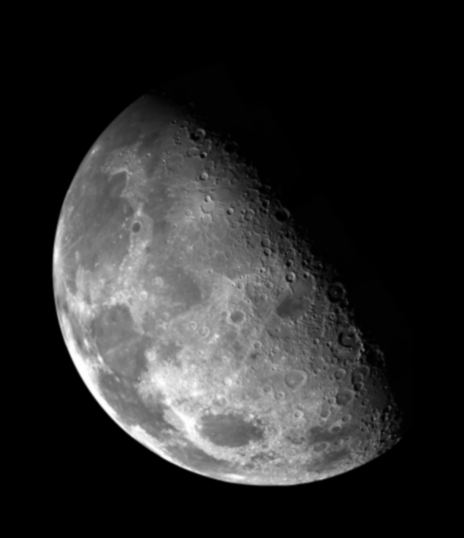

In [7]:
pics[6]

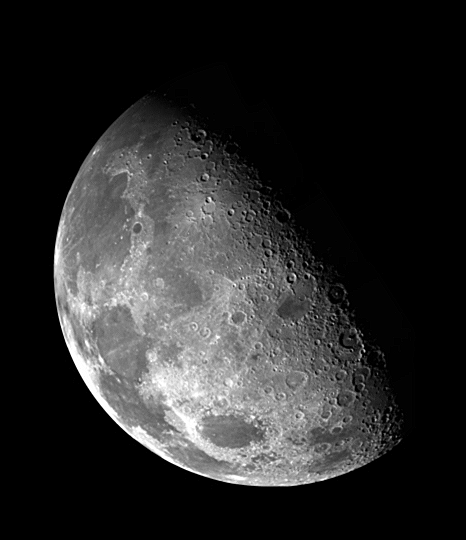

In [8]:
filter_sharpness_1(pics[6])

# 8. Градієнтна обробка

In [285]:
def filter_previt(img):
    npimg = np.asarray(img)
    wx1 = np.array([[1, 1, 1]])
    wx2 = np.array([[1, 0, -1]]).T
    dx1 = sps.convolve2d(npimg, wx1)
    dx = sps.convolve2d(dx1, wx2)

    wy1 = np.array([[1, 0, -1]])
    wy2 = np.array([[1, 1, 1]]).T
    dy1 = sps.convolve2d(npimg, wy1)
    dy = sps.convolve2d(dy1, wy2)

    # тут так багато коду бо я використав сепарабельність цього фільтру

    grad = np.sqrt(dx*dx + dy*dy)
    resimg = np.clip(grad, 0, 255).astype(np.uint8)
    
    return Image.fromarray(resimg)

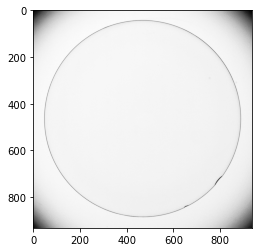

In [286]:
plt.imshow(pics[7], cmap='Greys_r')

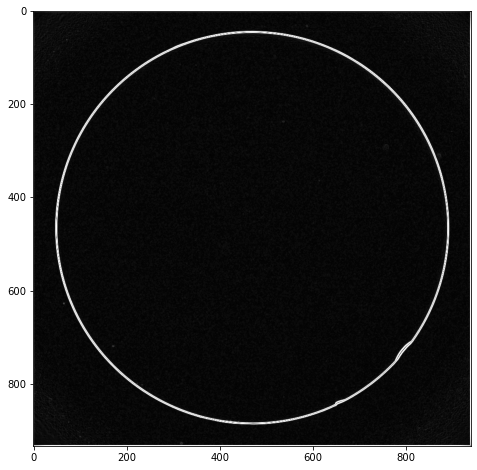

In [288]:
plt.imshow(filter_previt(pics[7]), cmap='Greys_r')
plt.gcf().set_size_inches((8,8))

# 9. Медіанний фільтр

In [9]:
def filter_median(img, r):
    npimg = np.asarray(img)
    n,m = npimg.shape
    resimg = np.zeros_like(npimg)
    k = int((r-1)/2)

    for i in range(k,n-k):
        for j in range(k,m-k):
            set = npimg[ i-k:i+k+1, j-k:j+k+1 ].flatten()
            set.sort()
            resimg[i,j] = set[int(set.shape[0]/2)]

    return resimg

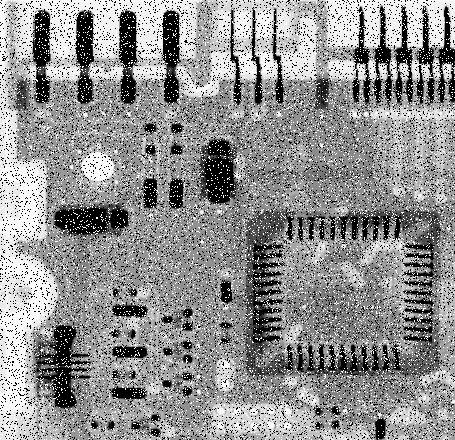

In [10]:
pics[8]

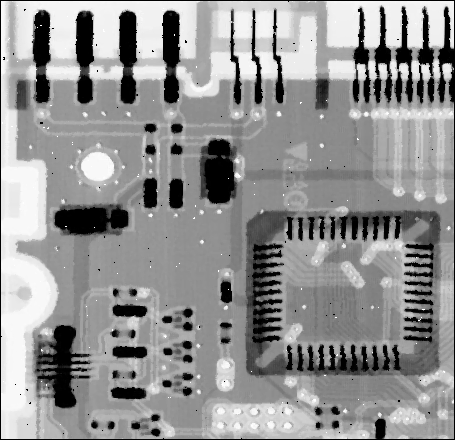

In [11]:
img = filter_median(pics[8], 3)
Image.fromarray(img)